### Исследовали 2 случая:  
$1) y'(A) = y'(-A) = z'(A) = z'(-A) = 0$ \
$2) y(A) = y(-A) = z(A) = z(-A) = 0 $

## КОД

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv, svd, norm
import random

In [30]:
colors = ['(255, 140, 0)', '(255, 69, 0)', '(154, 205, 50)', '(128, 128, 0)', '(85, 107, 47)',
              '(0, 128, 128)', '(70, 130, 180)', '(139, 69, 19)', '(105, 105, 105)']
random.shuffle(colors)
colors = [tuple(map(lambda x: int(x) / 255, color[1:-1].split(', '))) for color in colors]

In [42]:
def lambda_iterate(linsp, D, K, A, init_approx, system, bc, draw_nth, filename):
    global k11, k12, k13, k21, k22, k23
    k11, k12, k13, k21, k22, k23 = K
    global la
    params, bc_params = [], []
    lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
    lambdas_for_plot, dets = [], []
    lam_zeros = []
    lam_change_sign = []
    abcFile = open(filename, 'a')
    y_approx = init_approx
    cnt = 0
    time_steps = np.linspace(-A, A, 100)
    for la in lambdas:
        cnt += 1
        result = shooting(np.linspace(-A, A, 100), y_approx, system, params, bc, bc_params, filename)
        if result[0] > 1:
            print("MISTAKE AT la = ", la, "det = ", det, file=abcFile)
            continue
        print("y_approx = ", y_approx, " la = ", la, file = abcFile)
        if (len(dets) > 0 and result[3] * dets[-1] < 0):
            print("special lambda at", la)
            lam_zeros.append(la)
            return dets, lambdas_for_plot, lam_zeros, lam_change_sign
    # сохранить точку смены знака
        if len(dets) > 0 and result[3] * dets[-1] < 0:
            print('Det Change, lambda = {lamb}'.format(lamb = round(la, 2)))
            print("y_approx = ", y_approx, " la = ", la)
            lam_change_sign.append(la)
        y_approx = result[1]
        # la k1 k2
        lambdas_for_plot.append(la)
        dets.append(result[3])
    return dets, lambdas_for_plot, lam_zeros, lam_change_sign

def runge_kutta(f, y_value, steps):
    y = np.hstack((steps[0], y_value.copy()))
    for i in range(1, len(steps)):
        h = steps[i] - steps[i - 1]
        t1 = steps[i]
        k1 = count(f, y, 0, np.array([0] * (len(y) - 1)))
        k2 = count(f, y, h / 2, k1 * h / 2)
        k3 = count(f, y, h / 2, k2 * h / 2)
        k4 = count(f, y, h, k3 * h)
        y[1:] += h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y[0] = t1
    return y[1:]

def shooting(time_steps, y_approx, f, params, bc, bc_params, sourceFilename, solver=runge_kutta):
    # time_steps = np.linspace(-A, A, 100)
    global la
    boarder_values = bc
    y_value = y_approx
    eps = 1e-4
    step = 0
    determ = 0.0
    D = np.zeros((len(f), len(f)))
    left_steps, right_steps = time_steps[len(time_steps)//2::-1], time_steps[len(time_steps) // 2:]
#     print("len left steps, right steps = ", len(left_steps), len(right_steps))
    zeroDetFile = open('zeroDet.txt', 'a')
    while True:
        step += 1
        begin, end = np.array(runge_kutta(f, y_value, left_steps)), np.array(runge_kutta(f, y_value, right_steps))
#         print()
        redisuals = boarder_values(np.concatenate((begin, end)))
        if (np.abs(redisuals) < 1e-6).all():
            u, s, h = np.linalg.svd(D, full_matrices=False)
            return 0, y_value, redisuals, determ, s
        D = np.eye(len(f))
        for i in range(len(f)):
            y = y_value.copy()
            y[i] += eps
            dres = np.hstack((y, runge_kutta(f, y, time_steps)))
            begin, end = np.array(runge_kutta(f, y, left_steps )), np.array(runge_kutta(f, y, right_steps ))
            dres = np.hstack((begin, end))
            dr = boarder_values(dres)
            D[:, i] = (dr - redisuals) / eps
        determ = np.linalg.det(D)
        if abs(determ) < 1e-6:
#             u, s, h = np.linalg.svd(D, full_matrices=False)
            return 1, y_value, redisuals, determ, []
        if np.isnan(D).any():
            return 2, y_value, redisuals, determ, []
        if step > 50:
            return 3, y_value, redisuals, determ, []
        y_value = y_value - np.linalg.pinv(D) @ redisuals
    zeroDetFile.close()

def grkutta_(f, y_value, steps):   # different return
    y = np.hstack((steps[0], y_value.copy()))
    yval, zval = [y[1]], [y[2]]
    for i in range(1, len(steps)):
        h = steps[i] - steps[i - 1]
        t1 = steps[i]
        k1 = count(f, y, 0, np.array([0] * (len(y) - 1)))
        k2 = count(f, y, h / 2, k1 * h / 2)
        k3 = count(f, y, h / 2, k2 * h / 2)
        k4 = count(f, y, h, k3 * h)
        y[1:] += h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y[0] = t1
        yval.append(y[1])
        zval.append(y[2])
    return list(steps), yval, zval


def count(f, args, h, k):
    ''' calculates f(args[0] + h, args[1:] + k) '''
    res = []
    args0 = args.copy()
    args0[0] += h
    args0[1:] += k
    for i in range(len(f)):
        res.append(f[i](args0))
    return np.array(res)
def F1(args):
    x, y, z, dy, dz = args[:5]
    return dy
def F2(args):
    global la, k11, k12, k13
    x, y, z, dy, dz = args[:5]
    return (y + k11 * y**2 + 2 * k12 * z * y + k13 * z**2 + la) / D    # d^2y / dx^2
def G1(args):
    x, y, z, dy, dz = args[:5]
    return dz
def G2(args):
    global la, k21, k22, k23
    x, y, z, dy, dz = args[:5]
    return (z + k21 * y**2 + 2 * k22 * z * y + k23 * z**2 + la) / D     # d^2z / dx^2

system = [F1, G1, F2, G2]

# def boarder_values_(l):
#     return np.array([l[0], l[1], l[4], l[5]])
# #  0      1      2      3     4    5    6     7   
# # y(-A) z(-A) y'(-A) z'(-A) y(A) z(A) y'(A) z'(A)

# bc = boarder_values_
params = []


def boarder_values(l):
    return np.array([l[2], l[3], l[6], l[7]])
#  0      1      2      3     4    5    6     7   
# y(-A) z(-A) y'(-A) z'(-A) y(A) z(A) y'(A) z'(A)

bc = boarder_values

## D

In [48]:
D_pos = []
from tqdm import tqdm
filename = "bifucation_set"
import warnings
warnings.filterwarnings("ignore")
size = 20
linespk11 = np.linspace(10., 20., size)
matrix_dets_D_pos = []
matrix_lambda_for_plot_D_pos = []
linsp = [0., 2., 100]
firsts_D = []
for ind1, ij1 in tqdm(enumerate(linespk11)):
        D, A = ij1, 2.0
        K1, K2 = 1.57, 10
        k11, k12, k13, k21, k22, k23 = 0, K1, K2, 0, K2, K1
        init_approx = [0] * 4
        lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
        print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = ij1, A = A, K1 = 1.57, K2 = 10, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
        K = [k11, k12, k13, k21, k22, k23]
        dets, lambdas_for_plot, la_zero, la_change = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 1000, filename)
        dets = dets[1:]
        lambdas_for_plot = lambdas_for_plot[1:]
        if len(la_zero) == 0:
            continue
#         fig = plt.figure(figsize=(15, 5))
#         ax = fig.gca()
#         ax.set_xlabel("Lambda")
#         ax.set_ylabel("Det")
#         plt.scatter(lambdas_for_plot, dets, s = 3, color = 'red')
#         plt.title('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij1, K2 = ij2, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
#         plt.grid()
#         plt.show()
        print("first root = ", la_zero[0])
        firsts_D.append(la_zero[0])
        D_pos.append(D)


0it [00:00, ?it/s]

D = 10.0, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


1it [00:23, 23.27s/it]

special lambda at 0.4040404040404041
first root =  0.4040404040404041
D = 10.526315789473685, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


2it [00:46, 23.14s/it]

special lambda at 0.42424242424242425
first root =  0.42424242424242425
D = 11.052631578947368, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


3it [01:04, 21.78s/it]

special lambda at 0.4444444444444445
first root =  0.4444444444444445
D = 11.578947368421053, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


4it [01:23, 20.88s/it]

special lambda at 0.4646464646464647
first root =  0.4646464646464647
D = 12.105263157894736, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


5it [02:04, 26.80s/it]

special lambda at 1.8383838383838385
first root =  1.8383838383838385
D = 12.631578947368421, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


6it [02:20, 23.59s/it]

special lambda at 0.5050505050505051
first root =  0.5050505050505051
D = 13.157894736842106, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


7it [03:11, 31.99s/it]

D = 13.68421052631579, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


8it [03:50, 33.96s/it]

special lambda at 0.5454545454545455
first root =  0.5454545454545455
D = 14.210526315789473, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


9it [04:36, 37.51s/it]

D = 14.736842105263158, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


10it [05:01, 33.92s/it]

special lambda at 0.5858585858585859
first root =  0.5858585858585859
D = 15.263157894736842, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


11it [05:32, 32.98s/it]

special lambda at 0.6060606060606061
first root =  0.6060606060606061
D = 15.789473684210526, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


12it [06:32, 41.08s/it]

D = 16.315789473684212, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


13it [06:56, 36.05s/it]

special lambda at 0.6464646464646465
first root =  0.6464646464646465
D = 16.842105263157894, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


14it [07:35, 36.96s/it]

special lambda at 0.6666666666666667
first root =  0.6666666666666667
D = 17.36842105263158, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


15it [08:06, 35.20s/it]

special lambda at 0.686868686868687
first root =  0.686868686868687
D = 17.894736842105264, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


16it [08:40, 34.58s/it]

special lambda at 0.7070707070707072
first root =  0.7070707070707072
D = 18.421052631578945, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


17it [09:05, 31.70s/it]

special lambda at 0.7272727272727273
first root =  0.7272727272727273
D = 18.94736842105263, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


18it [09:33, 30.59s/it]

special lambda at 0.7474747474747475
first root =  0.7474747474747475
D = 19.473684210526315, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


19it [09:55, 28.11s/it]

special lambda at 0.7676767676767677
first root =  0.7676767676767677
D = 20.0, A = 2.0, K1 = 1.57, K2 = 10, linspace(0.0, 2.0, 100)


20it [10:21, 31.07s/it]

special lambda at 0.787878787878788
first root =  0.787878787878788


Text(0.5, 1.0, 'Первая особая лямбда в зависимости от D, k1 = 1.57, k2 = 10')

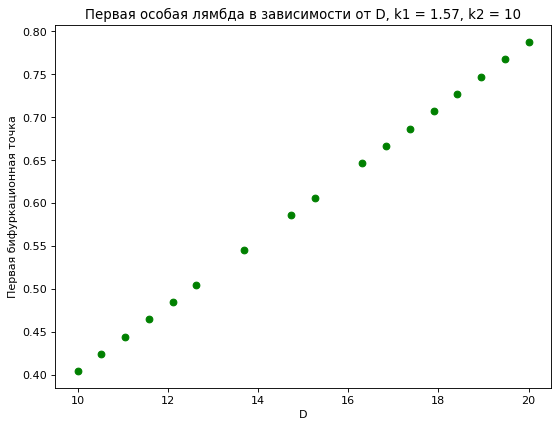

In [53]:
for i in range(len(D_pos)):
    if firsts_D[i] > 1:
        firsts_D[i] = (firsts_D[i - 1] + firsts_D[i + 1]) / 2
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(D_pos, firsts_D, c="green", label="First special lambda")
plt.xlabel("D")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от D, k1 = 1.57, k2 = 10")


In [49]:
D_pos_ = []
from tqdm import tqdm
filename = "bifucation_set"
import warnings
warnings.filterwarnings("ignore")
size = 20
linespk11 = np.linspace(10., 20., size)
matrix_dets_D_pos_ = []
matrix_lambda_for_plot_D_pos_ = []
linsp = [0., 2., 100]
firsts_D_ = []
for ind1, ij1 in tqdm(enumerate(linespk11)):
        D, A = ij1, 2.0
        K1, K2 = 2, 10
        k11, k12, k13, k21, k22, k23 = 0, K1, K2, 0, K2, K1
        init_approx = [0] * 4
        lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
        print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = ij1, A = A, K1 = 2, K2 = 10, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
        K = [k11, k12, k13, k21, k22, k23]
        dets, lambdas_for_plot, la_zero, la_change = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 1000, filename)
        dets = dets[1:]
        lambdas_for_plot = lambdas_for_plot[1:]
        if len(la_zero) == 0:
            continue
#         fig = plt.figure(figsize=(15, 5))
#         ax = fig.gca()
#         ax.set_xlabel("Lambda")
#         ax.set_ylabel("Det")
#         plt.scatter(lambdas_for_plot, dets, s = 3, color = 'red')
#         plt.title('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij1, K2 = ij2, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
#         plt.grid()
#         plt.show()
        print("first root = ", la_zero[0])
        firsts_D_.append(la_zero[0])
        D_pos_.append(D)


0it [00:00, ?it/s]

D = 10.0, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


1it [00:26, 26.26s/it]

special lambda at 0.4444444444444445
first root =  0.4444444444444445
D = 10.526315789473685, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


2it [01:11, 31.85s/it]

special lambda at 1.696969696969697
first root =  1.696969696969697
D = 11.052631578947368, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


3it [01:31, 28.34s/it]

special lambda at 0.48484848484848486
first root =  0.48484848484848486
D = 11.578947368421053, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


4it [01:59, 28.40s/it]

special lambda at 0.5050505050505051
first root =  0.5050505050505051
D = 12.105263157894736, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


5it [02:14, 24.26s/it]

special lambda at 0.5252525252525253
first root =  0.5252525252525253
D = 12.631578947368421, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


6it [02:44, 25.95s/it]

special lambda at 0.5454545454545455
first root =  0.5454545454545455
D = 13.157894736842106, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


7it [03:32, 32.74s/it]

D = 13.68421052631579, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


8it [04:03, 32.08s/it]

special lambda at 0.5858585858585859
first root =  0.5858585858585859
D = 14.210526315789473, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


9it [04:42, 34.31s/it]

special lambda at 0.6060606060606061
first root =  0.6060606060606061
D = 14.736842105263158, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


10it [05:06, 30.94s/it]

special lambda at 0.6262626262626263
first root =  0.6262626262626263
D = 15.263157894736842, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


11it [05:41, 32.26s/it]

special lambda at 0.6464646464646465
first root =  0.6464646464646465
D = 15.789473684210526, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


12it [06:23, 35.25s/it]

special lambda at 0.6666666666666667
first root =  0.6666666666666667
D = 16.315789473684212, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


13it [06:43, 30.76s/it]

special lambda at 0.686868686868687
first root =  0.686868686868687
D = 16.842105263157894, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


14it [07:28, 34.81s/it]

special lambda at 0.7070707070707072
first root =  0.7070707070707072
D = 17.36842105263158, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


15it [07:56, 32.78s/it]

special lambda at 0.7272727272727273
first root =  0.7272727272727273
D = 17.894736842105264, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


16it [08:23, 31.06s/it]

special lambda at 0.7474747474747475
first root =  0.7474747474747475
D = 18.421052631578945, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


17it [08:58, 32.29s/it]

special lambda at 0.7676767676767677
first root =  0.7676767676767677
D = 18.94736842105263, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


18it [09:40, 35.11s/it]

special lambda at 0.787878787878788
first root =  0.787878787878788
D = 19.473684210526315, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


19it [10:15, 35.26s/it]

special lambda at 0.8080808080808082
first root =  0.8080808080808082
D = 20.0, A = 2.0, K1 = 2, K2 = 10, linspace(0.0, 2.0, 100)


20it [10:45, 32.27s/it]

special lambda at 0.8282828282828284
first root =  0.8282828282828284


Text(0.5, 1.0, 'Первая особая лямбда в зависимости от D, k1 = 2, k2 = 10')

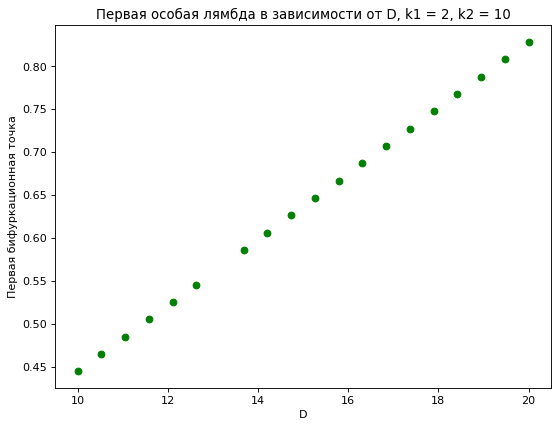

In [55]:
for i in range(len(D_pos_)):
    if firsts_D_[i] > 1:
        firsts_D_[i] = (firsts_D_[i - 1] + firsts_D_[i + 1]) / 2
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(D_pos_, firsts_D_, c="green", label="First special lambda")
plt.xlabel("D")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от D, k1 = 2, k2 = 10")
